In [ ]:
import numpy as np
import pandas as pd
import torch
from torchvision.transforms import v2
from torchvision import datasets, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##### your directory should be structured as

- my-notebook.ipynb

- SkinDisease
    - train
    - test

In [3]:
train_dir = "SkinDisease/train"
test_dir = "SkinDisease/test"

img_sz = 224
batch_sz = 32

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

##### Transformations


In [4]:
train_aug = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((img_sz, img_sz)),
    # v2.RandomCrop
    v2.RandomHorizontalFlip(),
    v2.GaussianBlur(kernel_size=[3, 5], sigma=(0.1, 2)),
    # v2.ToImageTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

test_aug = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((img_sz, img_sz)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

##### leaning about our dataset .....
1. how many images and classes --> plot them on a graph

In [5]:
class_names = []
img_count = []

for dir in os.listdir(train_dir):
    # print(dir)
    class_names.append(dir)
    img_count.append(len([file for file in os.listdir(train_dir +'/'+ dir)]))


print("No.of class labels we have is:", len(class_names))

for i in range(len(class_names)):
    print(class_names[i])

No.of class labels we have is: 22
Benign_tumors
Vitiligo
Infestations_Bites
Warts
Unknown_Normal
Eczema
Moles
Vascular_Tumors
Acne
Lichen
Sun_Sunlight_Damage
SkinCancer
Candidiasis
Actinic_Keratosis
Tinea
Psoriasis
DrugEruption
Lupus
Seborrh_Keratoses
Rosacea
Bullous
Vasculitis


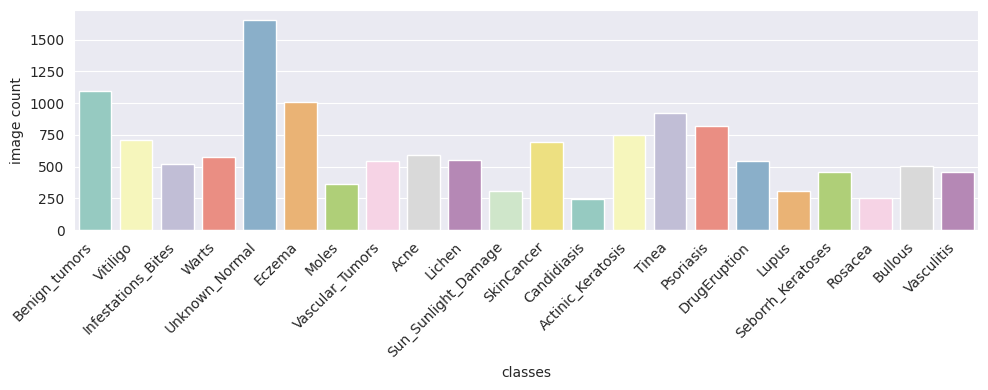

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=img_count, palette='Set3')
plt.xlabel('classes')
plt.ylabel('image count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [7]:
print(img_count)

[1093, 714, 524, 580, 1651, 1010, 361, 543, 593, 553, 312, 693, 248, 748, 923, 820, 547, 311, 455, 254, 504, 461]


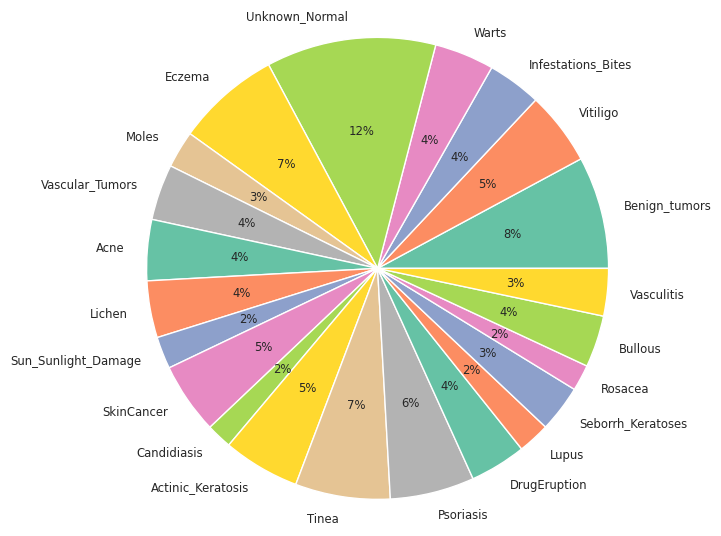

In [11]:
plt.figure(figsize=(5, 5))
colors = sns.color_palette('Set2')
plt.pie(img_count, labels=class_names, autopct='%.0f%%', colors=colors, textprops={'size': 'smaller'}, radius=1.5)
plt.show()

##### uneven number of exaples in the dataset makes it biased, need to apply some techniques

##### dataset loading 

In [8]:
train_set = datasets.ImageFolder(train_dir, transform=train_aug)
test_set = datasets.ImageFolder(test_dir, transform=test_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)  
# labels = train_set.classes

# print(len(labels), labels)


##### visualization

torch.Size([32, 3, 224, 224])


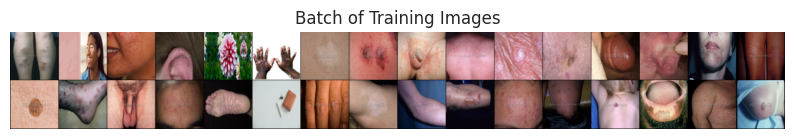

In [9]:
dataiter = iter(train_loader)

img_batch, label_batch = next(dataiter)

print(img_batch.shape)
mean_tensor = torch.tensor(mean).reshape(1, 3, 1, 1)
std_tensor = torch.tensor(std).reshape(1, 3, 1, 1)

# Denormalize the batch
img_batch = img_batch * std_tensor + mean_tensor


# Create grid
img_grid = make_grid(img_batch, nrow=16)  # Adjust nrow as needed

# Convert to HWC
img_grid = img_grid.permute(1, 2, 0).numpy().clip(0, 1)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(img_grid)
plt.title("Batch of Training Images")
plt.axis('off')
plt.show()

In [10]:
labels =  train_set.targets

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=np.array(labels))

class_weights = torch.tensor(class_weights,  dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"📊 Class weights tensor: {class_weights}")

📊 Class weights tensor: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='cuda:0')


##### Model: Resnet

In [12]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.3)
print("✅ Model ready and optimizer configured.")

✅ Model ready and optimizer configured.


##### train split + validation

In [11]:
from torch.utils.data import random_split, DataLoader

split_ratio = 0.1

train_size = int((1 - split_ratio) * len(train_set))
val_size = len(train_set) - train_size

train_split, val_split = random_split(train_set, [train_size, val_size])

### dataloader
train_split_loader = DataLoader(train_split, batch_size=32, shuffle=True, num_workers=2) 
val_split_loader = DataLoader(val_split, batch_size=32, shuffle=True, num_workers=2) 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import copy

### lets start with loss function ---
loss_fn=  nn.CrossEntropyLoss(weight=class_weights) # the one you caluculated before using resnet model weights

# now move on to optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, min_lr=1e-6)

EPOCHS = 20
best_val_acc = 0
patience = 4 ## whats this ?? only god knows
early_stop_cnt = 0 
save_path = "best.pt"

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, corr, total = 0.0, 0, 0

    
    for images, labels in train_split_loader:
        images = images.to(device)
        labels = labels.to(device)

        # print(images.shape)

        optimizer.zero_grad() #make zero gards to None to save space
        outputs = model(images) # output our model after giving it images
        loss = loss_fn(outputs, labels) # loss function with input labels and output guesses
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        corr += predicted.eq(labels).sum().item()


    train_loss = running_loss / total 
    train_acc = corr / total 
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    ## evaluation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_split_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= total
    val_acc = correct/ total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


    #for early stopping 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), save_path)
        print(" Best model saved ")
        early_stop_cnt = 0

    else:
        early_stop_cnt += 1
        if early_stop_cnt >= patience:
            print("early stopping triggered !!!")
            break


model.load_state_dict(torch.load(save_path))
print("✅ Training complete. Best model loaded.")

##### Test set evaluations

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


model.eval()
all_pred, all_labels = [], []
print(len(test_loader))
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        _, pred = torch.max(output, 1)
        all_pred.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

file_1 = "pred.txt"
file_2 = "labels.txt"

with open(file_1, 'a') as file:
    for item in all_pred:
        file.write(f"{item}\n")

with open(file_2, 'a') as file:
    for item in all_labels:
        file.write(f"{item}\n")

print("all_pred rows, cols:", np.array(all_pred).shape)
print("all_labels rows, cols:", np.array(all_labels).shape)
print(classification_report(all_labels, all_pred, target_names=class_names))

49
all_pred rows, cols: (1546,)
all_labels rows, cols: (1546,)
                     precision    recall  f1-score   support

      Benign_tumors       0.64      0.71      0.67        65
           Vitiligo       0.52      0.60      0.56        83
 Infestations_Bites       0.45      0.58      0.51       121
              Warts       0.52      0.55      0.53        55
     Unknown_Normal       0.50      0.59      0.54        27
             Eczema       0.53      0.44      0.48        61
              Moles       0.57      0.57      0.57       112
    Vascular_Tumors       0.52      0.40      0.45        60
               Acne       0.55      0.56      0.55        61
             Lichen       0.50      0.32      0.39        34
Sun_Sunlight_Damage       0.56      0.47      0.51        40
         SkinCancer       0.62      0.53      0.57        88
        Candidiasis       0.73      0.68      0.70        28
  Actinic_Keratosis       0.65      0.59      0.62        51
              Tinea  

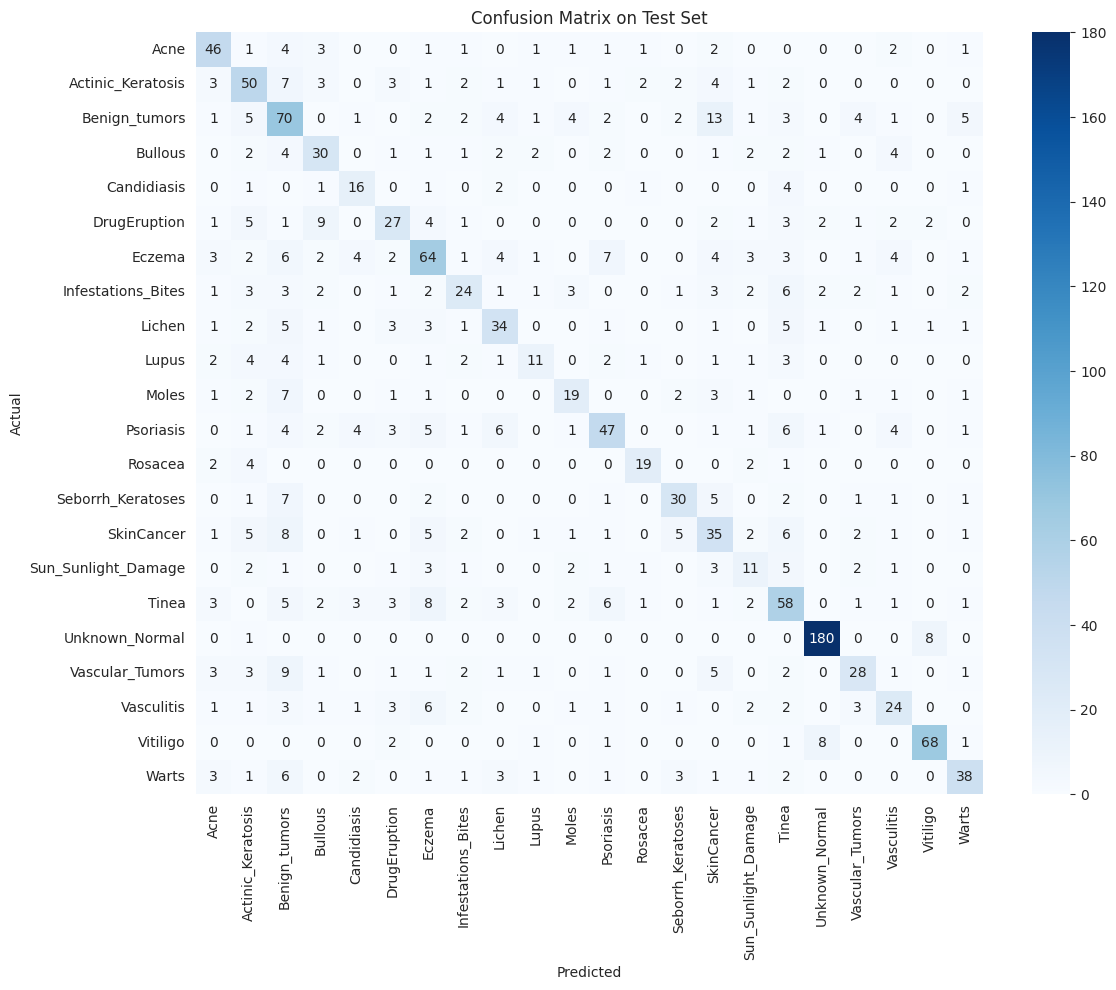

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_pred)
labels = test_set.classes

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.jpg')
plt.show()

##### using efficientnet

In [13]:
## caluculate weights
labels = train_set.targets
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=np.array(labels))
class_weights = torch.tensor(class_weights,  dtype=torch.float).to(device)

###### lets use focal class as the criterion

##### New model: efficientnet

In [15]:
from torchvision.models import efficientnet_b2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import copy

##### Transformations

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [18]:
model = efficientnet_b2(weights='DEFAULT')
model.to(device)

criterion = FocalLoss(alpha = 0.25, gamma = 2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.5)

##### Training loop 

In [ ]:
EPOCHS = 20
best_val_acc = 0
patience, counter = 5, 0
checkpt_path = "efficientnet-best.pth"

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, labels in train_loader